# ball and stick model mean local conductance

In [1]:
from neuron import h
from neuron.units import ms, mV
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import plotly
from neuron import clear_gui_callback
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
from scipy.integrate import cumtrapz
from numpy.linalg import pinv, eig
import numpy as np
h.load_file("stdrun.hoc")
from multiprocessing import Pool
font2={'family':'Times New Roman',
'weight':'bold',
'size': 12}

from matplotlib.ticker import FuncFormatter
def format_func(value, tick_number):
    return f'{value:.0f}'  # 将刻度值格式化为小数点后两位

def plot_curve(ax2,x,y,z, cmap='coolwarm',title='', linestyle='-',xlim=[0,100],dx=20,
               ylim=[0,10],dy=5.0, fontsize=10, alpha = 1.0, xlabel='Time/ms', zlabel='',
               ylabel = 'Frequency/Hz', label='',ynum_decimals =1,xnum_decimals =1, zlim=[0,100],dz=20,
               nonscatter=True, s0=10, nondoubley=True, plottype = 'scatter', color='b'):
    if plottype=='scatter':
        surf = ax2.scatter(x, y, z,  c=z, cmap=cmap, s=50, alpha=0.7, edgecolor='w')
    if plottype=='trisurf':
        surf = ax2.plot_trisurf(x, y, z, cmap=cmap, edgecolor='none', alpha=0.8)
    if plottype=='line':
        surf = ax2.plot(x, y, linestyle=linestyle, alpha=alpha, label=label, color=color)
        
    ax2.set_xlabel(xlabel,font2)
    ax2.set_ylabel(ylabel,font2)

    
    def format_funcx(value, tick_number, num_decimals=xnum_decimals):
        if num_decimals==0:
            return f'{value:.0f}'
        return f'{value:.{num_decimals}f}'

    def format_funcy(value, tick_number, num_decimals=ynum_decimals):
        if num_decimals==0:
          return f'{value:.0f}'
        return f'{value:.{num_decimals}f}'

    # if dx:
    #     ax2.set_xticks(np.arange(xlim[0], xlim[1] + dx, dx))
    #     ax2.set_xticklabels(ax2.get_xticks(), fontsize=fontsize, weight='bold')
    #     ax2.set_xlim([xlim[0], xlim[1]])
    #     ax2.xaxis.set_major_formatter(FuncFormatter(format_funcx))

    if dy:
        ax2.set_yticks(np.arange(ylim[0], ylim[1] + dy, dy))
        ax2.set_yticklabels(ax2.get_yticks(), fontsize=fontsize, weight='bold')
        ax2.set_ylim([ylim[0], ylim[1]])
        ax2.yaxis.set_major_formatter(FuncFormatter(format_funcy))
        
  
    if dx:
       ax2.set_xticks(np.arange(xlim[0],xlim[1]+dx,dx))
       ax2.set_xticklabels(np.arange(xlim[0],xlim[1]+dx,dx),fontsize=10,weight='bold')
       ax2.set_xlim(xlim)
       ax2.xaxis.set_major_formatter(FuncFormatter(format_funcx))
       
    if dz:
       ax2.set_zticks(np.arange(zlim[0],zlim[1]+dz,dz))
       ax2.set_zticklabels(np.arange(zlim[0],zlim[1]+dz,dz),fontsize=10,weight='bold')
       ax2.set_zlim(zlim)
       ax2.zaxis.set_major_formatter(FuncFormatter(format_funcx))
       ax2.set_zlabel(zlabel,font2)
    # if ylim:
    #    ax2.set_yticks(np.arange(ylim[0],ylim[1]+dy,dy))
    #    ax2.set_yticklabels(np.arange(ylim[0],ylim[1]+dy,dy),fontsize=10,weight='bold')
    #    ax2.set_ylim(ylim)
    if title:
       ax2.set_title('{0}'.format(title),fontsize=fontsize,weight='bold')
    ax2.spines['top'].set_visible(False)
    if nondoubley:
        ax2.spines['right'].set_visible(False)
    if label:
       ax2.legend(loc='best',prop=font2,edgecolor='white')
    # ax2.grid(False)
    return surf

--No graphics will be displayed.


0.0746802999053033


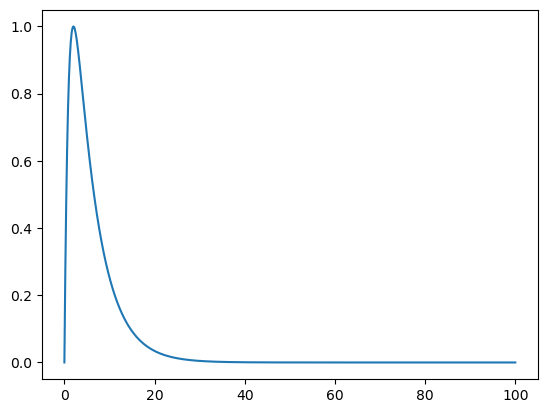

In [2]:
run_dt=0.1
syn_tau1 = 1.
syn_tau2 = 5.
t=np.arange(0,100+run_dt,run_dt)
NE = ((syn_tau1/syn_tau2)**(syn_tau1/(syn_tau2-syn_tau1))-(syn_tau1/syn_tau2)**(syn_tau2/(syn_tau2-syn_tau1)))**-1
uE = NE*(np.exp(-t/syn_tau2)-np.exp(-t/syn_tau1))
plt.plot(t,uE)
ground_truth = np.mean(uE)
print(ground_truth)

In [3]:
def recovery_of_local_conductance(run_dt, fE, E = True, L_dend = 100, diam_dend = 50, loc = 0., dV=10., diam_soma = 50, dend_soma = 10):


     # set morphology
    soma = h.Section(name='soma')
    soma.nseg = 1
    soma.diam = diam_soma
    soma.L = dend_soma
    # set biophysics
    soma.Ra = 100.
    soma.insert('pas')
    soma.g_pas = 5e-5
    soma.e_pas = -70.

    dend = h.Section(name='dend')  
    dend.nseg = 100
    dend.diam = diam_dend
    # dend.L = 600
    dend.L = L_dend
    dend.Ra = 100
    dend.insert('pas')
    dend.g_pas = 5e-5
    dend.e_pas = -70.
    area_soma = soma.L *np.pi*soma.diam
    area_dend = dend.L *np.pi*dend.diam
    dend.connect(soma(1))

    # Set simulation parameters
    h.dt = run_dt
    h.tstop = 200.
    h.v_init = -70.
    v_clamp = -70.
    
    recv = h.Vector().record(soma(0.5)._ref_v)


    # Initialize an excitatory or inhibitory synaptic input
    # make a new stimulator
    stim = h.NetStim()
    syn = h.Exp2Syn(dend(loc))
    syn.tau1 = 1.  # ms
    syn.tau2 = 5.  # ms
    if E:
        syn.e = 0.  # mV for E input and -100 for I input
    else: 
        syn.e = -100.
    # print(syn.e)
        
    stim.number = 1
    stim.start = 100.  # ms
    ncstim = h.NetCon(stim, syn)
    ncstim.delay = 0.
    ncstim.weight[0] = 0.  # uS


    # Initialize voltage clamp
    vclamp = h.SEClamp(soma(0.5))
    vclamp.amp1 = v_clamp
    vclamp.dur1 = h.tstop
    vclamp.amp2 = v_clamp - 20.

    irec = h.Vector()
    irec.record(vclamp._ref_i)

    # Function to initialize the simulation
    def initialize():
        h.t = 0
        h.finitialize(h.v_init)
        h.fcurrent()

    # Function to integrate the simulation
    def integrate():
        while h.t < h.tstop:
            h.fadvance()

    # Function to run the simulation
    def go():
        initialize()
        integrate()

    # Main simulation loop
    def main():
    
        Vclamp = np.arange(-100.,-60., dV) 
        Isyn_inj = np.zeros(len(Vclamp))
        vclamp.dur1 = 0.
        vclamp.dur2 = 0.
        vclamp.dur3 = 0.
        ncstim.weight[0] = 0.
        go()
        recv0 = np.array(recv.to_python())
        V_rest = recv0[2000]
        # print(V_rest)
        Isyn_inj_t = np.zeros((len(Vclamp),1000))

        for i in range(len(Vclamp)):
            ncstim.weight[0] = 0.
            vclamp.amp1 = Vclamp[i]
            vclamp.dur1 = h.tstop
            go()
            
            Isyn0 = np.array(irec.to_python())  # Assuming irec is a NEURON Vector
            ncstim.weight[0] = fE
            vclamp.amp1 = Vclamp[i]
            vclamp.dur1 = h.tstop
            go()
            Isyn1 = np.array(irec.to_python())  # Assuming irec is a NEURON Vector
            Isyn= - (Isyn1[1001:] - Isyn0[1001:])
            # Isyn_inj[i] = np.sum(Isyn*run_dt)
            Isyn_inj[i] = np.mean(Isyn)
            Isyn_inj_t[i,:] = Isyn
        
            
        A = np.ones((len(Vclamp),2))
        A[:,0] = Vclamp - V_rest
        A1 = Vclamp - V_rest
        x, residuals, rank, singular_values = np.linalg.lstsq(A, Isyn_inj, rcond=None)
        
        
        if E:
            mean_local_conductance = - x[1]**2/(x[0]*(0. - V_rest)**2)
            A1 = A1 - (0. - V_rest)
        else:
            mean_local_conductance = - x[1]**2/(x[0]*(-100.- V_rest)**2)
            A1 = A1 - (-100. - V_rest)
            
        traditional_effective_conductance = np.zeros(1000)
        for i in range(1000):
            a = np.sum(A1 * Isyn_inj_t[:,i]) / np.sum(A1**2)  # 计算斜率
            traditional_effective_conductance[i] = - a
            
        traditional_mean_conductance = np.mean(traditional_effective_conductance)
        
        return mean_local_conductance, traditional_mean_conductance, A, Isyn_inj
    
    
    mean_local_conductance, traditional_mean_conductance, A, Isyn_inj = main()
    
    return mean_local_conductance, traditional_mean_conductance

    

# dependence on diameter and L(location)

In [51]:
diam_dend = np.linspace(1.,20,100)
mean_local_conductance_us_total = []
traditional_mean_conductance_total = []
for i, diam_dend0 in enumerate(diam_dend):
    def recovery_of_local_conductance_parallel(args):
        loc0, = args
        mean_local_conductance, traditional_mean_conductance = recovery_of_local_conductance(0.1, 1e-3, E = True, L_dend = 1000, diam_dend = diam_dend0, loc = loc0)
        return mean_local_conductance, traditional_mean_conductance


    loc=np.linspace(0.,1.,100)
    # Create a Pool with desired number of processes (adjust as needed)
    num_processes = 50
    with Pool(num_processes) as pool:
        # Prepare arguments for parallel processing
        args_list = [(loc0,) for loc0 in loc]

        # Apply the function in parallel
        results = pool.map(recovery_of_local_conductance_parallel, args_list)

    mean_local_conductance0 = np.zeros(len(loc))
    traditional_mean_conductance0 = np.zeros(len(loc))
    # Process the results
    for i, result in enumerate(results):
        mean_local_conductance0[i], traditional_mean_conductance0[i] = result
    mean_local_conductance_us_total.append(mean_local_conductance0)
    traditional_mean_conductance_total.append(traditional_mean_conductance0)
np.savetxt('mean_local_conductance_us_total.txt', mean_local_conductance_us_total)
np.savetxt('traditional_mean_conductance_total.txt', traditional_mean_conductance_total)

In [5]:
mean_local_conductance_us_total = np.loadtxt('mean_local_conductance_us_total.txt')
traditional_mean_conductance_total = np.loadtxt('traditional_mean_conductance_total.txt')
fE = 1e-3
ge = ground_truth*fE
error_us = []
error_trad = []
diam_dend0 = np.linspace(1.,20,100)
loc0 = np.linspace(0.,1.,100)*1000
diam_dend  =[]
loc = []
for i in range(len(diam_dend0)):
    for j in range(len(loc0)):
        diam_dend.append(diam_dend0[i])
        loc.append(loc0[j])
        error_us.append(np.abs(mean_local_conductance_us_total[i][j] - ge))
        error_trad.append(np.abs(traditional_mean_conductance_total[i][j] - ge))

In [7]:
print(np.min(error_us), np.max(error_us))

3.230753566150352e-11 1.636247465812928e-05


<>:19: SyntaxWarning: invalid escape sequence '\m'
<>:20: SyntaxWarning: invalid escape sequence '\m'
<>:19: SyntaxWarning: invalid escape sequence '\m'
<>:20: SyntaxWarning: invalid escape sequence '\m'
/tmp/ipykernel_2973099/2288154308.py:19: SyntaxWarning: invalid escape sequence '\m'
  ylim=[0,1000],dy=500, fontsize=12, alpha = 1.0, xlabel='Diameter ($\mu m$)', zlim=[0,2e-5], dz=1e-5,
/tmp/ipykernel_2973099/2288154308.py:20: SyntaxWarning: invalid escape sequence '\m'
  ylabel = 'Path distance ($\mu m$)', zlabel='Error', label='',ynum_decimals =0,xnum_decimals =0,
findfont: Font family 'Times New Roman' not found.
findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.
/tmp/ipykernel_2973099/2288154308.py:41: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not foun

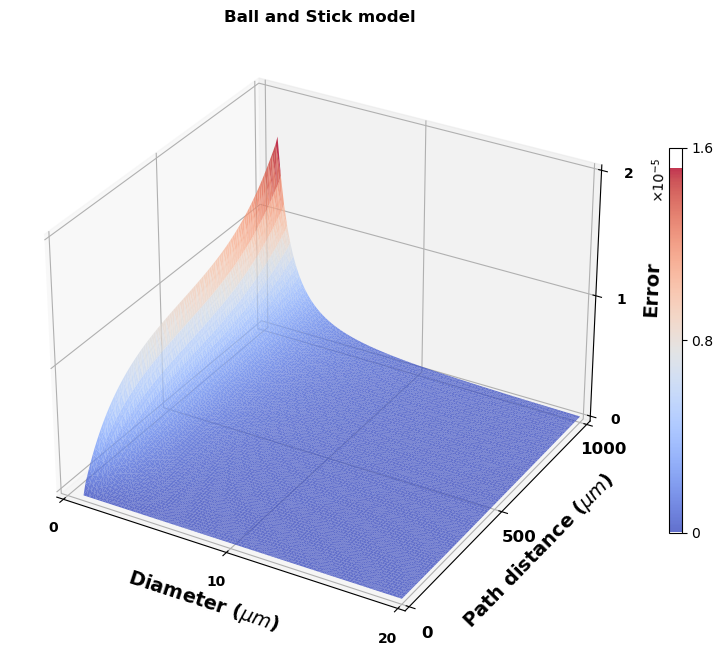

In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
font2={'family':'Times New Roman',
'weight':'bold',
'size': 14}


# 假设您的数据 (x, y, z)
x = diam_dend  # 替换为您的 x 数据
y = loc        # 替换为您的 y 数据
z = error_us   # 替换为您的 z 数据

# 创建画布和三维坐标系
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')

surf=plot_curve(ax,x,y,z, cmap='coolwarm',title='Ball and Stick model', linestyle='-',xlim=[0,20], dx=10,
               ylim=[0,1000],dy=500, fontsize=12, alpha = 1.0, xlabel='Diameter ($\mu m$)', zlim=[0,2e-5], dz=1e-5,
               ylabel = 'Path distance ($\mu m$)', zlabel='Error', label='',ynum_decimals =0,xnum_decimals =0, 
               nonscatter=True, s0=10, nondoubley=True, plottype = 'trisurf')
from matplotlib.ticker import ScalarFormatter
ax.zaxis.set_major_formatter(ScalarFormatter(useMathText=True))
# ax.scatter(x, y, z,  c='black', s=2, alpha=0.2)


# # 使用 trisurf 绘制三维表面图
# surf = ax.plot_trisurf(x, y, z, cmap='coolwarm', edgecolor='none', alpha=0.8)

# # 设置坐标轴标签
# ax.set_xlabel('Diameter ($\mu m$)', fontsize=12, weight='bold', labelpad=20)
# ax.set_ylabel('Path distance ($\mu m$)', fontsize=12, weight='bold', labelpad=20)
# ax.set_zlabel('Relative Error', fontsize=12, weight='bold', labelpad=20)

# 显示颜色条
cbar = fig.colorbar(surf, ax=ax, shrink=0.5, aspect=30)

# 设置 colorbar 的刻度标签
cbar.set_ticks([0, e-5, 1.6e-5])  # 设置刻度位置
cbar.set_ticklabels(['0', '0.8', '1.6'])  
plt.tight_layout()
plt.savefig('error_diameter_distance_ball_stick.eps', format='eps', dpi=1000)

# 显示图形
plt.show()


# dependence on $f_E$

In [217]:
def recovery_of_local_conductance_parallel(args):
    fE0, = args
    mean_local_conductance, traditional_mean_conductance = recovery_of_local_conductance(0.1, fE0, E = True, L_dend = 1000, diam_dend = 4, loc = 0.5, dend_soma=5)
    return mean_local_conductance, traditional_mean_conductance


fE=np.linspace(1e-4,1e-2,100)
# Create a Pool with desired number of processes (adjust as needed)
num_processes = 50
with Pool(num_processes) as pool:
    # Prepare arguments for parallel processing
    args_list = [(fE0,) for fE0 in fE]

    # Apply the function in parallel
    results = pool.map(recovery_of_local_conductance_parallel, args_list)

mean_local_conductance0 = np.zeros(len(fE))
traditional_mean_conductance0 = np.zeros(len(fE))
# Process the results
for i, result in enumerate(results):
    mean_local_conductance0[i], traditional_mean_conductance0[i] = result
np.savetxt('mean_local_conductance0.txt', mean_local_conductance0)
np.savetxt('traditional_mean_conductance0.txt', traditional_mean_conductance0)

findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.


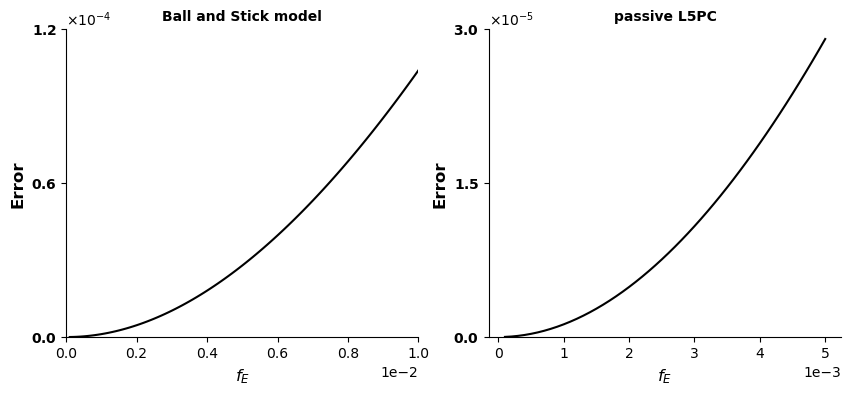

In [5]:
fE=np.linspace(1e-4,1e-2,100)
error_ball = []
mean_local_conductance0 = np.loadtxt('mean_local_conductance0.txt')
for i, mean_local_conductance in enumerate(mean_local_conductance0):
    ge = fE[i]*ground_truth
    error_ball.append(np.abs(mean_local_conductance - ge))
fig = plt.figure(figsize=(10, 4))
ax = fig.add_subplot(121)
z=[]
plot_curve(ax,fE,error_ball,z, cmap='coolwarm', title='Ball and Stick model', linestyle='-',xlim=[0,1e-2 ], dx=0e-3,
               ylim=[0,1.2e-4],dy=0.6e-4, fontsize=10, alpha = 1.0, xlabel='$f_E$', zlim=[0,30], dz=0,
               ylabel = 'Error', zlabel='Relative error', label='', ynum_decimals =0,xnum_decimals =3, 
               nonscatter=True, s0=10, nondoubley=True, plottype = 'line', color='black')
from matplotlib.ticker import ScalarFormatter
ax.yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
# ax.xaxis.set_major_formatter(ScalarFormatter(useMathText=True))
ax.ticklabel_format(style='sci', axis='x', scilimits=(0, 0))

ax.set_xlim([0,1e-2])
ax.set_ylim([0,1.2e-4])
ax.ticklabel_format(style='sci', axis='y', scilimits=(0, 0))  # 强制使用科学计数法


estimated_mean_cond = np.loadtxt('/home/wzl/LFPy/project/conductance_measurement/realistic_neuron/L5PC_neuron/local_conductance/estimated_mean_cond_passive_apicloc34_fE.txt')
fE1 = np.linspace(1e-4, 5e-3, 50) # for E

error_L5 = []
for i, mean_local_conductance in enumerate(estimated_mean_cond):
    ge = fE1[i]*ground_truth
    error_L5.append(np.abs(mean_local_conductance[0] - ge))

ax1 = fig.add_subplot(122)
plot_curve(ax1,fE1,error_L5,z, cmap='coolwarm', title='passive L5PC', linestyle='-',xlim=[0,5e-3 ], dx=0e-3,
               ylim=[0,3e-5],dy=1.5e-5, fontsize=10, alpha = 1.0, xlabel='$f_E$', zlim=[0,30], dz=0,
               ylabel = 'Error', zlabel='Relative error', label='', ynum_decimals =1,xnum_decimals =1, 
               nonscatter=True, s0=10, nondoubley=True, plottype = 'line', color='black')


ax1.yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
ax1.ticklabel_format(style='sci', axis='x', scilimits=(0, 0))






plt.savefig('error_fE_ball_stick.eps', format='eps', dpi=1000)
plt.show()

# ax.scatter(x, y, z,  c='black', s=2, alpha=0.2)


findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'T

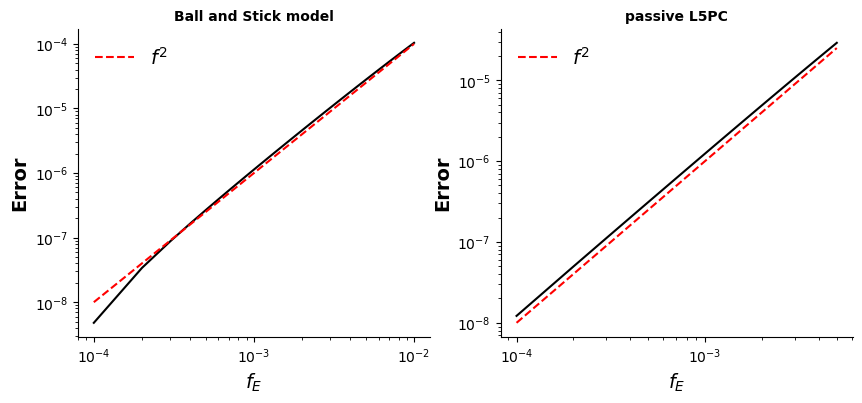

In [9]:
fE=np.linspace(1e-4,1e-2,100)
error_ball = []
mean_local_conductance0 = np.loadtxt('mean_local_conductance0.txt')
for i, mean_local_conductance in enumerate(mean_local_conductance0):
    ge = fE[i]*ground_truth
    error_ball.append(np.abs(mean_local_conductance - ge))
fig = plt.figure(figsize=(10, 4))
ax = fig.add_subplot(121)
plot_curve(ax,fE,error_ball,z, cmap='coolwarm', title='Ball and Stick model', linestyle='-',xlim=[0,1e-2 ], dx=0e-3,
               ylim=[0,1.2e-4],dy=0.e-4, fontsize=10, alpha = 1.0, xlabel='$f_E$', zlim=[0,30], dz=0,
               ylabel = 'Error', zlabel='Relative error', label='', ynum_decimals =0,xnum_decimals =3, 
               nonscatter=True, s0=10, nondoubley=True, plottype = 'line', color='black')
plot_curve(ax,fE,fE**2,z, cmap='coolwarm', title='Ball and Stick model', linestyle='--',xlim=[0,1e-2 ], dx=0e-3,
               ylim=[0,1.2e-4],dy=0.e-4, fontsize=10, alpha = 1.0, xlabel='$f_E$', zlim=[0,30], dz=0,
               ylabel = 'Error', zlabel='Relative error', label='$f^2$', ynum_decimals =0,xnum_decimals =3, 
               nonscatter=True, s0=10, nondoubley=True, plottype = 'line', color='red')


# 设置 x 和 y 轴为对数刻度
ax.set_xscale('log')
ax.set_yscale('log')


estimated_mean_cond = np.loadtxt('/home/wzl/LFPy/project/conductance_measurement/realistic_neuron/L5PC_neuron/local_conductance/estimated_mean_cond_passive_apicloc34_fE.txt')
fE1 = np.linspace(1e-4, 5e-3, 50) # for E

error_L5 = []
for i, mean_local_conductance in enumerate(estimated_mean_cond):
    ge = fE1[i]*ground_truth
    error_L5.append(np.abs(mean_local_conductance[0] - ge))

ax1 = fig.add_subplot(122)
plot_curve(ax1,fE1,error_L5,z, cmap='coolwarm', title='L5PC', linestyle='-',xlim=[0,5e-3 ], dx=0e-3,
               ylim=[0,3e-5],dy=0e-5, fontsize=10, alpha = 1.0, xlabel='$f_E$', zlim=[0,30], dz=0,
               ylabel = 'Error', zlabel='Relative error', label='', ynum_decimals =1,xnum_decimals =1, 
               nonscatter=True, s0=10, nondoubley=True, plottype = 'line', color='black')

plot_curve(ax1,fE1,fE1**2,z, cmap='coolwarm', title='passive L5PC', linestyle='--',xlim=[0,1e-2 ], dx=0e-3,
               ylim=[0,1.2e-4],dy=0.e-4, fontsize=10, alpha = 1.0, xlabel='$f_E$', zlim=[0,30], dz=0,
               ylabel = 'Error', zlabel='Relative error', label='$f^2$', ynum_decimals =0,xnum_decimals =3, 
               nonscatter=True, s0=10, nondoubley=True, plottype = 'line', color='red')



# 设置 x 和 y 轴为对数刻度
ax1.set_xscale('log')
ax1.set_yscale('log')

plt.savefig('error_fE_ball_stick.eps', format='eps', dpi=1000)
plt.show()



findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'T

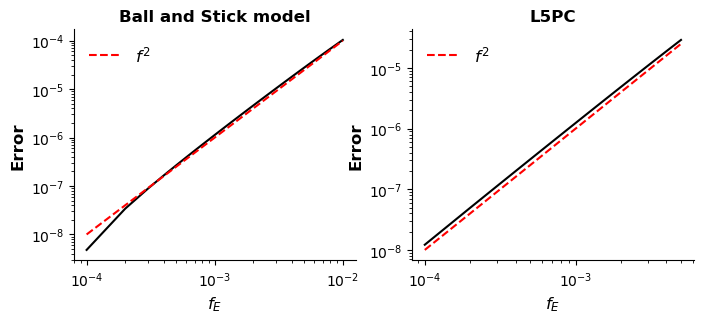

In [229]:
fE=np.linspace(1e-4,1e-2,100)
error_ball = []
mean_local_conductance0 = np.loadtxt('mean_local_conductance0.txt')
for i, mean_local_conductance in enumerate(mean_local_conductance0):
    ge = fE[i]*ground_truth
    error_ball.append(np.abs(mean_local_conductance - ge))
fig = plt.figure(figsize=(8, 3))
ax = fig.add_subplot(121)
plot_curve(ax,fE,error_ball,z, cmap='coolwarm', title='Ball and Stick model', linestyle='-',xlim=[0,1e-2 ], dx=0e-3,
               ylim=[0,1.2e-4],dy=0.e-4, fontsize=10, alpha = 1.0, xlabel='$f_E$', zlim=[0,30], dz=0,
               ylabel = 'Error', zlabel='Relative error', label='', ynum_decimals =0,xnum_decimals =3, 
               nonscatter=True, s0=10, nondoubley=True, plottype = 'line', color='black')
plot_curve(ax,fE,fE**2,z, cmap='coolwarm', title='Ball and Stick model', linestyle='--',xlim=[0,1e-2 ], dx=0e-3,
               ylim=[0,1.2e-4],dy=0.e-4, fontsize=10, alpha = 1.0, xlabel='$f_E$', zlim=[0,30], dz=0,
               ylabel = 'Error', zlabel='Relative error', label='$f^2$', ynum_decimals =0,xnum_decimals =3, 
               nonscatter=True, s0=10, nondoubley=True, plottype = 'line', color='red')


# 设置 x 和 y 轴为对数刻度
ax.set_xscale('log')
ax.set_yscale('log')


estimated_mean_cond = np.loadtxt('/home/wzl/LFPy/project/conductance_measurement/realistic_neuron/L5PC_neuron/local_conductance/estimated_mean_cond_passive_apicloc34_fE.txt')
fE1 = np.linspace(1e-4, 5e-3, 50) # for E

error_L5 = []
for i, mean_local_conductance in enumerate(estimated_mean_cond):
    ge = fE1[i]*ground_truth
    error_L5.append(np.abs(mean_local_conductance[0] - ge))

ax1 = fig.add_subplot(122)
plot_curve(ax1,fE1,error_L5,z, cmap='coolwarm', title='L5PC', linestyle='-',xlim=[0,5e-3 ], dx=0e-3,
               ylim=[0,3e-5],dy=0e-5, fontsize=10, alpha = 1.0, xlabel='$f_E$', zlim=[0,30], dz=0,
               ylabel = 'Error', zlabel='Relative error', label='', ynum_decimals =1,xnum_decimals =1, 
               nonscatter=True, s0=10, nondoubley=True, plottype = 'line', color='black')

plot_curve(ax1,fE1,fE1**2,z, cmap='coolwarm', title='L5PC', linestyle='--',xlim=[0,1e-2 ], dx=0e-3,
               ylim=[0,1.2e-4],dy=0.e-4, fontsize=10, alpha = 1.0, xlabel='$f_E$', zlim=[0,30], dz=0,
               ylabel = 'Error', zlabel='Relative error', label='$f^2$', ynum_decimals =0,xnum_decimals =3, 
               nonscatter=True, s0=10, nondoubley=True, plottype = 'line', color='red')



# 设置 x 和 y 轴为对数刻度
ax1.set_xscale('log')
ax1.set_yscale('log')

plt.savefig('error_fE_ball_stick.eps', format='eps', dpi=1000)
plt.show()

